In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# titanic data

Najpierw zaloguj się do https://www.kaggle.com/ i przejdź do wyzwania https://www.kaggle.com/c/titanic, aby pobrać 
 * train.csv i test.csv. 

Zapisz je w katalogu datasets/titanic.

In [2]:
import os
TITANIC_PATH = os.path.join("data", "titanic")

In [3]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [4]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

* Dane są już podzielone na zestaw treningowy i zestaw testów. 
* Jednak dane testowe nie zawierają etykiet: Twoim celem jest wyszkolenie najlepszego modelu, który możesz wykorzystać w danych treningowych, następnie dokonanie swoich przewidywań na danych testowych i przesłanie ich do Kaggle, aby zobaczyć ostateczny wynik.

Rzućmy okiem na kilka pierwszych rzędów zestawu treningowego:

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

* Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* Pclass: passenger class.
* Name, Sex, Age: self-explanatory
* SibSp: how many siblings & spouses of the passenger aboard the Titanic.
* Parch: how many children & parents of the passenger aboard the Titanic.
* Ticket: ticket id
* Fare: price paid (in pounds)
* Cabin: passenger's cabin number
* Embarked: where the passenger embarked the Titanic
* Let's get more info to see how much data is missing:

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Atrybuty **Age**, **Cabin** oraz **Embarked** są czasami zerowe (mniej niż 891 wartości bez wartości null), szczególnie w przypadku **Cabin** (77% ma wartość zerową). Zignorujemy teraz **Cabin** i skupimy się na reszcie. Atrybut **Age** ma około 19% wartości pustych, więc będziemy musieli zdecydować, co z nimi zrobić. Zastąpienie wartości null medianą wieku wydaje się uzasadnione.

Atrybuty **Name** i **Ticket** mogą mieć pewną wartość, ale będą one nieco trudne do przekształcenia w użyteczne liczby. Na razie będziemy je ignorować.

Rzućmy okiem na atrybuty liczbowe:

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Tylko 38% przeżyło: to wystarczająco blisko do 40%, więc **accuracy** będzie rozsądną miarą do oceny naszego modelu.

Sprawdźmy, czy etykiety przyjmują wartości 0 lub 1:

Nie zapomnij o etykietach:

In [8]:
train_data['Survived'].unique()

array([0, 1])

Teraz rzućmy okiem na wszystkie atrybuty kategoryczne:

In [9]:
categorical = train_data.select_dtypes(include=['object'])
print(categorical.isnull().sum())
categorical

Name          0
Sex           0
Ticket        0
Cabin       687
Embarked      2
dtype: int64


,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...
886,"Montvila, Rev. Juozas",male,211536,NaN,S
887,"Graham, Miss. Margaret Edith",female,112053,B42,S
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S
889,"Behr, Mr. Karl Howell",male,111369,C148,C


In [10]:
categorical['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [11]:
categorical['Cabin'].value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
F2             3
E101           3
              ..
A16            1
E46            1
C111           1
C95            1
A34            1
Name: Cabin, Length: 147, dtype: int64

In [12]:
categorical['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Atrybut **Embarked** mówi nam, gdzie pasażer zaokrętował: C = Cherbourg, Q = Queenstown, S = Southampton.

Teraz zbudujmy nasze **pipeline** preprocessingu. 

Wykorzystamy DataframeSelector aby wybrać określone atrybuty z DataFrame:

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

X, y = train_data.drop(['Survived'], axis=1), train_data['Survived']

print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (891, 11) y.shape: (891,)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Zbudujmy **pipeline** dla atrybutów numerycznych:

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(X_train.select_dtypes(exclude=['object']).columns)),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [16]:
num_pipeline.fit_transform(X_train)

array([[332.    ,   1.    ,  45.5   ,   0.    ,   0.    ,  28.5   ],
       [734.    ,   2.    ,  23.    ,   0.    ,   0.    ,  13.    ],
       [383.    ,   3.    ,  32.    ,   0.    ,   0.    ,   7.925 ],
       ...,
       [861.    ,   3.    ,  41.    ,   2.    ,   0.    ,  14.1083],
       [436.    ,   1.    ,  14.    ,   1.    ,   2.    , 120.    ],
       [103.    ,   1.    ,  21.    ,   0.    ,   1.    ,  77.2875]])

Będziemy także potrzebować imputera do kategorycznych kolumn  napisowych (zwykły Imputer nie działa na tych kolumnach):

In [17]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Teraz możemy zbudować **pipeline** dla atrybutów kategorycznych:

In [18]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(X_train.select_dtypes(include=['object']).columns)),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

In [19]:
cat_pipeline.fit_transform(X_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

Na koniec połączmy powyższe podejścia:

In [20]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Teraz mamy fajny **pipeline** przetwarzania wstępnego, który pobiera dane wejściowe i zwraca dane wyjściowe złorzone z liczb, które możemy podać do dowolnego modelu uczenia maszynowego.

# Zad

Robimy StratifiedKFold i znajdujemy optymalne parametry dla

* SVM z jądrem rbf
* SVM z jądrem poly
* SVM liniowego
* Regresji logistycznej

In [21]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [22]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [23]:
from sklearn import  metrics

models = []

def get_scores(name, model):
    precision_score = metrics.precision_score(y_test, model.predict(X_test))
    recall_score = metrics.recall_score(y_test, model.predict(X_test))
    f1_score = metrics.f1_score(y_test, model.predict(X_test))
    accuracy_score = metrics.accuracy_score(y_test, model.predict(X_test))

    return dict(method=name, precision=precision_score, recall=recall_score, f1=f1_score, accuracy=accuracy_score)

def print_scores(scores):
    print(scores['method'])
    print("R^2: {}".format(scores['precision']))
    print("recall_score: {}".format(scores['recall']))
    print("f1_score: {}".format(scores['f1']))
    print("accuracy_score: {}".format(scores['accuracy']))

{'classifier__C': 1, 'classifier__gamma': 0.001}


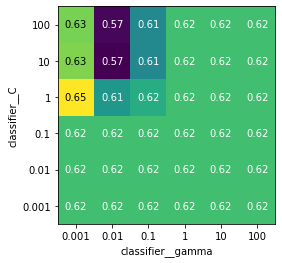

SVM rbf
R^2: 0.7241379310344828
recall_score: 0.28378378378378377
f1_score: 0.4077669902912622
accuracy_score: 0.659217877094972


In [24]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# SVC RBF KERNEL

# GRID

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='rbf'))
])


param_grid = {
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold)
grid_1.fit(X_train, y_train)
print(grid_1.best_params_)

# HEATMAP

results = pd.DataFrame(grid_1.cv_results_)
scores = np.array(results.mean_test_score).reshape(6, 6)
# plot the mean cross-validation scores WITH SCALER
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid['classifier__gamma'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()

# PRINT SCORES

models.append(('SVM rbf', grid_1.best_estimator_))
scores_1 = get_scores(*models[-1])
print_scores(scores_1)

In [25]:
# INSERT SCORES

summary = pd.DataFrame(data=scores_1, index=[0])
summary

,method,precision,recall,f1,accuracy
0,SVM rbf,0.724138,0.283784,0.407767,0.659218


{'classifier__C': 1000, 'classifier__degree': 2}


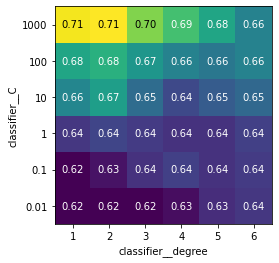

SVM poly
R^2: 0.7647058823529411
recall_score: 0.35135135135135137
f1_score: 0.48148148148148157
accuracy_score: 0.6871508379888268


,method,precision,recall,f1,accuracy
0,SVM rbf,0.724138,0.283784,0.407767,0.659218
1,SVM poly,0.764706,0.351351,0.481481,0.687151


In [26]:
# SVC POLY KERNEL

# GRID

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='poly'))
])

param_grid = {
            'classifier__degree': [i+1 for i in range(6)],
            'classifier__C': [0.01, 0.1, 1, 10, 100, 1000]
}

grid_2 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, n_jobs=4)

grid_2.fit(X_train, y_train)
print(grid_2.best_params_)

# HEATMAP

results = pd.DataFrame(grid_2.cv_results_)
scores = np.array(results.mean_test_score).reshape(6, 6)
# plot the mean cross-validation scores WITH SCALER
heatmap(scores, xlabel='classifier__degree', xticklabels=param_grid['classifier__degree'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()

# PRINT SCORES

models.append(('SVM poly', grid_2.best_estimator_))
scores_2 = get_scores(*models[-1])
print_scores(scores_2)

# INSERT SCORES

summary.loc[1] = scores_2
summary

{'classifier__C': 1, 'classifier__tol': 0.001}


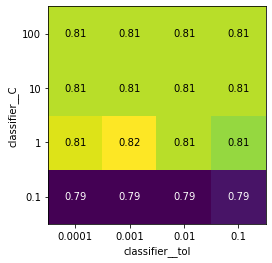

SVM linear
R^2: 0.835820895522388
recall_score: 0.7567567567567568
f1_score: 0.7943262411347517
accuracy_score: 0.8379888268156425


,method,precision,recall,f1,accuracy
0,SVM rbf,0.724138,0.283784,0.407767,0.659218
1,SVM poly,0.764706,0.351351,0.481481,0.687151
2,SVM linear,0.835821,0.756757,0.794326,0.837989


In [27]:
# SVC LINEAR KERNEL

# GRID
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='linear'))
])

param_grid = {
            'classifier__C': [0.1, 1, 10, 100],
            'classifier__tol': [1e-4, 1e-3, 1e-2, 1e-1]
}

grid_3 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, n_jobs=4)

grid_3.fit(X_train, y_train)
print(grid_3.best_params_)

# HEATMAP

results = pd.DataFrame(grid_3.cv_results_)
scores = np.array(results.mean_test_score).reshape(4, 4)
# plot the mean cross-validation scores WITH SCALER
heatmap(scores, xlabel='classifier__tol', xticklabels=param_grid['classifier__tol'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()

# PRINT SCORES

models.append(('SVM linear', grid_3.best_estimator_))
scores_3 = get_scores(*models[-1])
print_scores(scores_3)

# INSERT SCORES

summary.loc[2] = scores_3
summary

{'classifier__C': 100, 'classifier__solver': 'liblinear'}


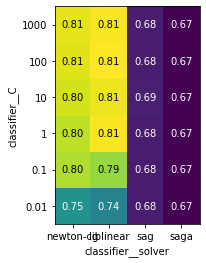

Linear Regression
R^2: 0.8235294117647058
recall_score: 0.7567567567567568
f1_score: 0.7887323943661971
accuracy_score: 0.8324022346368715


,method,precision,recall,f1,accuracy
0,SVM rbf,0.724138,0.283784,0.407767,0.659218
1,SVM poly,0.764706,0.351351,0.481481,0.687151
2,SVM linear,0.835821,0.756757,0.794326,0.837989
3,Linear Regression,0.823529,0.756757,0.788732,0.832402


In [28]:
# LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression

# GRID
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', LogisticRegression())
])

param_grid = {
            'classifier__solver': ['newton-cg', 'liblinear', 'sag', 'saga'],
            'classifier__C': [0.01, 0.1, 1, 10, 100, 1000]
}

grid_4 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, n_jobs=4)

grid_4.fit(X_train, y_train)
print(grid_4.best_params_)

# HEATMAP

results = pd.DataFrame(grid_4.cv_results_)
scores = np.array(results.mean_test_score).reshape(6, 4)
# plot the mean cross-validation scores WITH SCALER
heatmap(scores, xlabel='classifier__solver', xticklabels=param_grid['classifier__solver'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()

# PRINT SCORES

models.append(('Linear Regression', grid_4.best_estimator_))
scores_4 = get_scores(*models[-1])
print_scores(scores_4)

# INSERT SCORES

summary.loc[3] = scores_4
summary